In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Пред обработка

In [68]:
df = pd.read_csv("bank_loan_default.csv")
df.info()
display(df.shape)
display(df.head(5))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3041 non-null   int64  
 1   annual_income      3041 non-null   float64
 2   employment_type    3041 non-null   object 
 3   education          3041 non-null   object 
 4   loan_amount        3041 non-null   float64
 5   interest_rate_pct  3041 non-null   float64
 6   term_months        3041 non-null   int64  
 7   credit_score       3041 non-null   float64
 8   num_open_accounts  3041 non-null   int64  
 9   delinquency_30d    3041 non-null   object 
 10  residence_type     3041 non-null   object 
 11  Default            3041 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 285.2+ KB


(3041, 12)

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,Default
0,42,57272.0,Self-Employed,Masters,8516.0,5.85,48,730.0,10,No,Own,0
1,51,45786.0,Salaried,Masters,13760.0,9.97,36,677.0,7,No,Mortgage,0
2,69,42359.0,Salaried,Bachelors,2569.0,13.75,48,624.0,2,No,Own,0
3,65,50709.0,Self-Employed,Masters,13204.0,8.70,48,698.0,3,No,Rent,0
4,30,46272.0,Salaried,HS,7700.0,7.53,48,532.0,7,No,Rent,0


Переименование колонки


In [69]:
df.columns = df.columns.str.lower()


Проверка на неявные дубликаты


In [70]:
print(str(df.employment_type.value_counts()))
print(str(df.education.value_counts()))
print(str(df.residence_type.value_counts()))
print(str(df.delinquency_30d.value_counts()))


employment_type
Salaried         2132
Self-Employed     682
Unemployed        227
Name: count, dtype: int64
education
Bachelors    1181
HS            956
Masters       748
PhD           156
Name: count, dtype: int64
residence_type
Rent        1241
Own         1065
Mortgage     735
Name: count, dtype: int64
delinquency_30d
No     2668
Yes     373
Name: count, dtype: int64


В результате пред обработки данных проверены категориальные типы данных, неявных дубликатов не найдено. Явных дубликатов не найдено.
Исправлено название одного из признаков.

Целевым признаком в данном датасете является `default` - дефолт по кредиту.

Для выявление закономерностей построена матрица диаграмм рассеивания


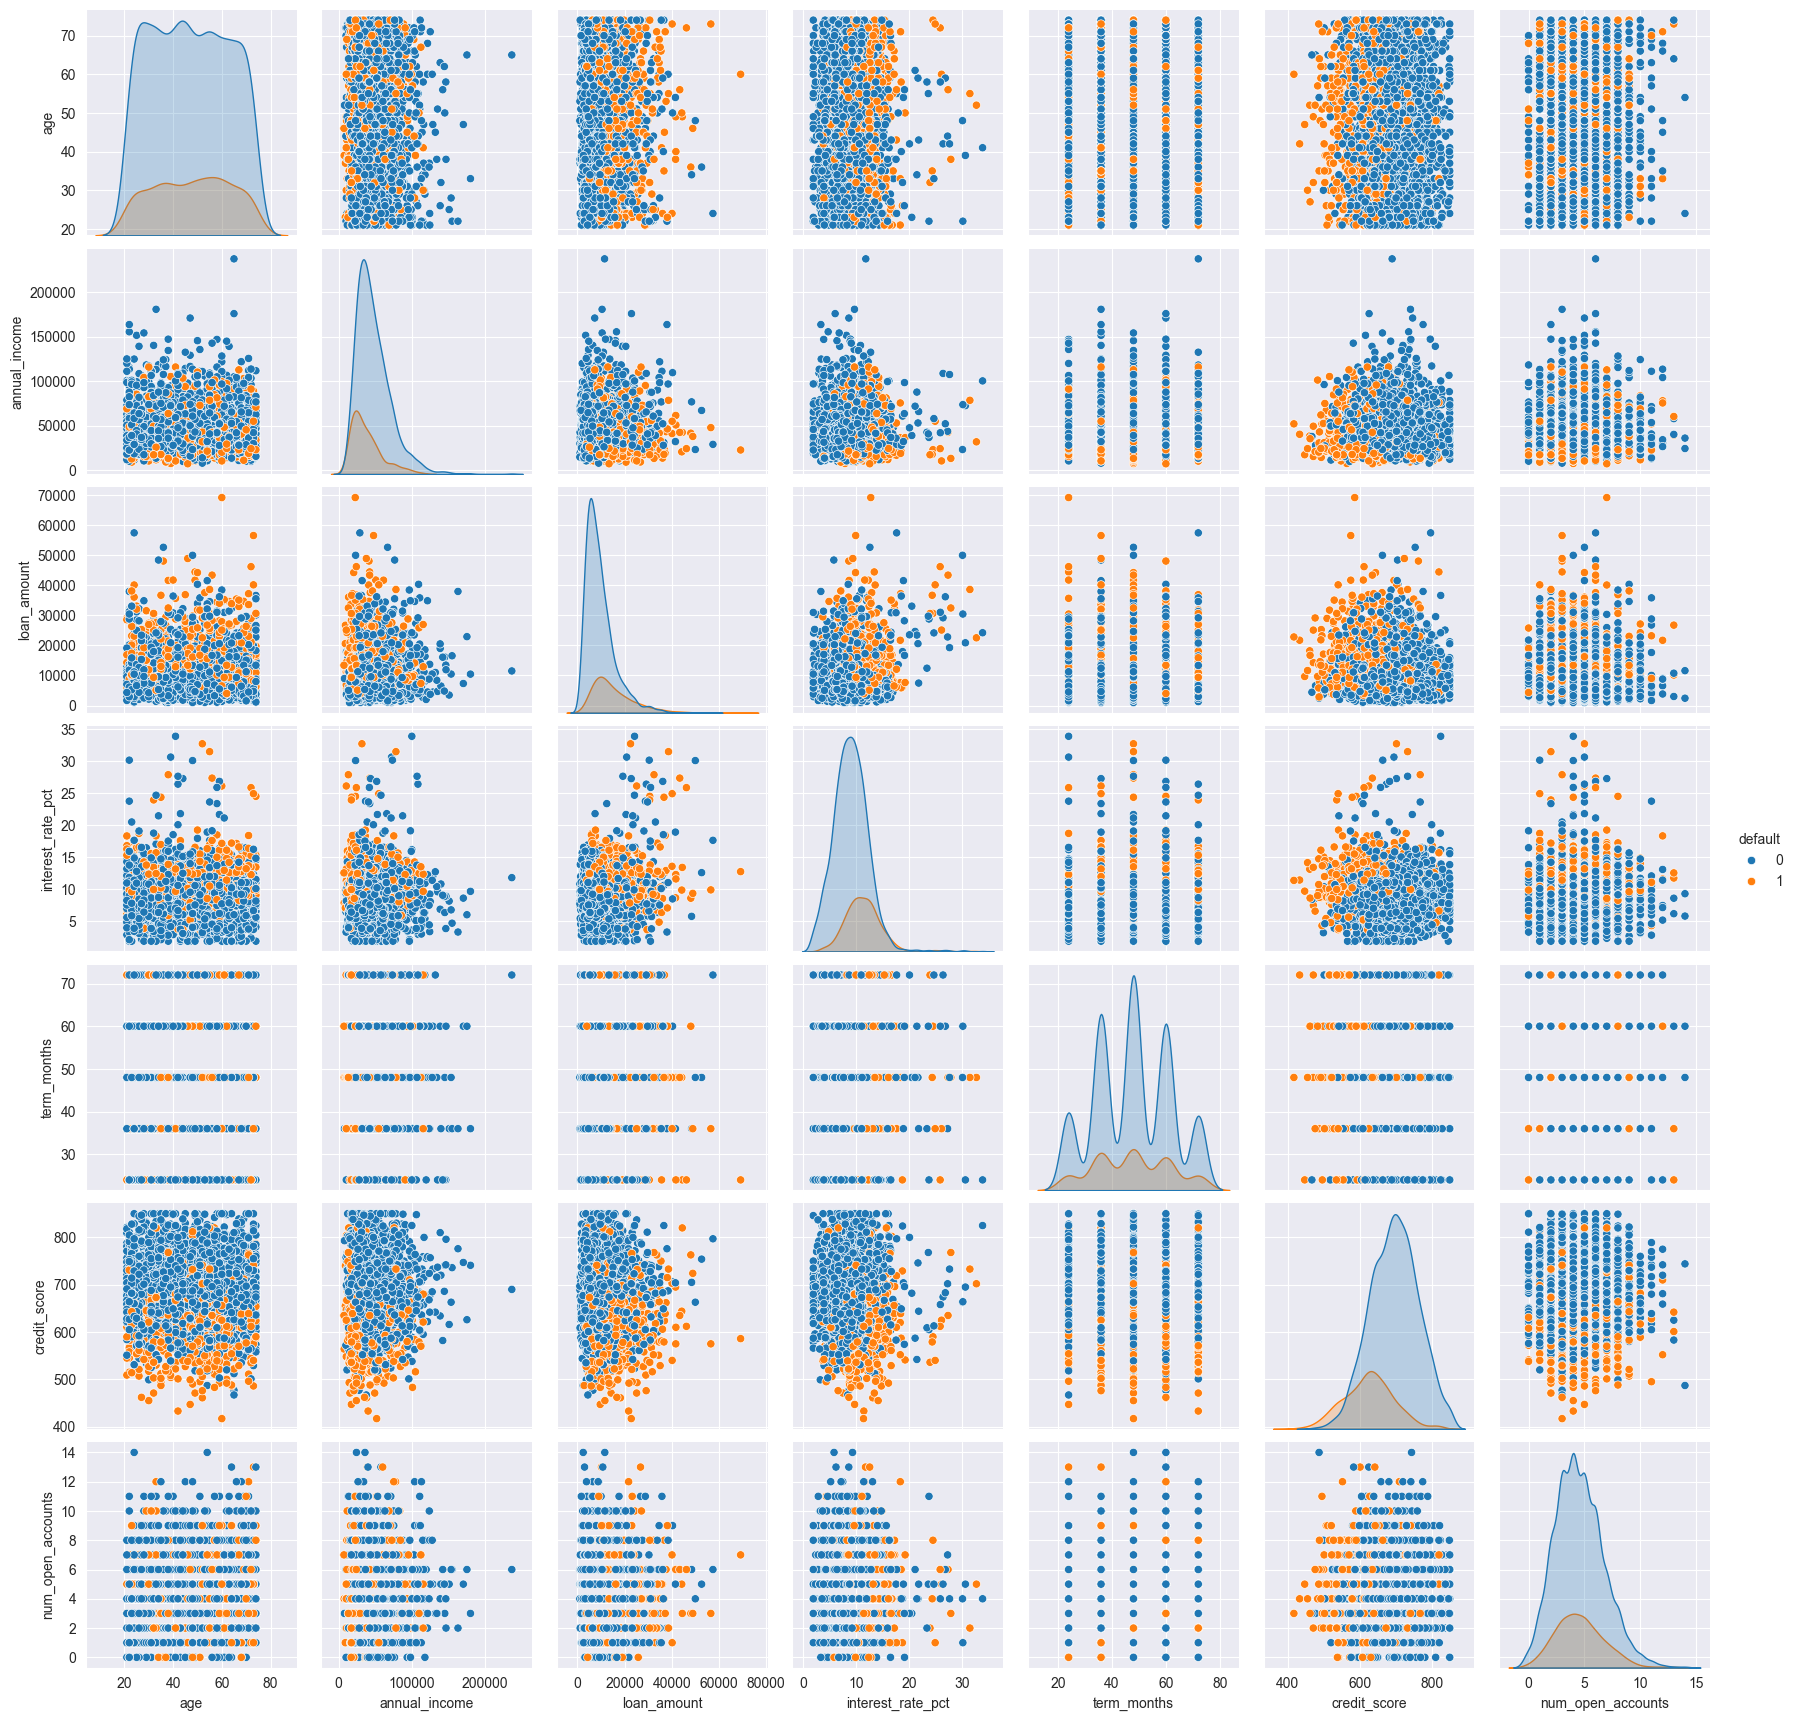

In [71]:
sns.pairplot(df, hue='default')

Визуально можно сделать следующие выводы:
- заемщики с меньшим процентом с меньшим шансом оказываются в дефолте
- чем выше кредитный счет, тем ниже шанс дефолта
- чем выше доход, тем ниже шанс дефолта

Возможно, более сложные зависимости не заметны визуально.

Выполним кодирование категориальных типов данных

In [72]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

df_src = df.copy()

for col in df.select_dtypes(include='object').columns:
    df[col] = oe.fit_transform(pd.DataFrame(df[col]))

Выполним стандартизацию числовых данных

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = df.default
X = df.drop('default', axis=1)
X = scaler.fit_transform(X)

Разделим на тренировочный и тестовый выборки

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# Обучение моделей

Обучим все четыре модели и сравним метрики каждой из них

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score, \
    confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    'метод k-ближайших соседей': KNeighborsClassifier(n_neighbors=5),
    'дерево решений': DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'),
    'логистическая регрессия': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'случайный лес': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

metrics = {
    # 'Confusion Matrix': confusion_matrix,
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'F1 Score': f1_score
}

metric_scores = {}
predictions = {}
probabilities = {}

for name, model in models.items():
    print()
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    predictions[name] = y_pred
    probabilities[name] = y_prob

    scores = {label: fn(y_test, y_pred) for label, fn in metrics.items()}
    metric_scores[name] = scores

    for label, value in scores.items():
        print(f"{label} = {value:.4f}")

    metric_scores[name]["confusion"] = confusion_matrix(y_test, y_pred)
    print(metric_scores[name]["confusion"])



метод k-ближайших соседей
Accuracy = 0.8237
Precision = 0.6636
Recall = 0.3622
Balanced Accuracy = 0.6560
F1 Score = 0.4686
[[681  36]
 [125  71]]

дерево решений
Accuracy = 0.7886
Precision = 0.5060
Recall = 0.6429
Balanced Accuracy = 0.7357
F1 Score = 0.5663
[[594 123]
 [ 70 126]]

логистическая регрессия
Accuracy = 0.7788
Precision = 0.4903
Recall = 0.7755
Balanced Accuracy = 0.7776
F1 Score = 0.6008
[[559 158]
 [ 44 152]]

случайный лес
Accuracy = 0.8467
Precision = 0.7373
Recall = 0.4439
Balanced Accuracy = 0.7003
F1 Score = 0.5541
[[686  31]
 [109  87]]


Выбор модели в данном случае зависит от требований бизнеса, так как есть несколько хороших кандидатов со своими плюсами и минусами.

Если приоритет - выявить как можно больше дефолтов (минимум FN), то лучше подходит логистическая регрессия: лучший recall, лучший F1 и сбалансированная точность.

Если приоритет - сократить ошибочные отказы (минимум FP), то лучше подходит случайный лес: лучший precision и точность.

Визуализируем полученные матрицы неточностей

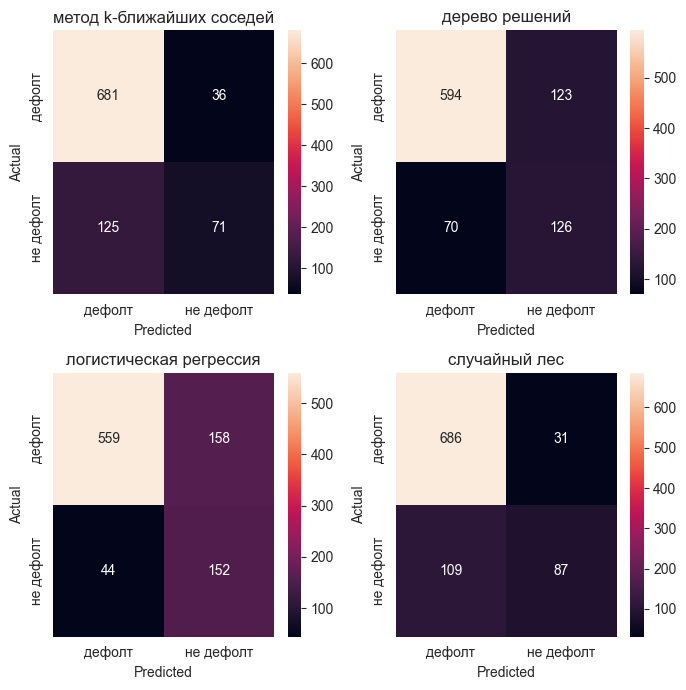

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.flatten()

for idx, name in enumerate(predictions.keys()):
    sns.heatmap(metric_scores[name]["confusion"], annot=True, fmt='d',
                xticklabels=['дефолт', 'не дефолт'],
                yticklabels=['дефолт', 'не дефолт'],
                ax=axes[idx])

    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

Выбор модели зависит от задачи бизнеса: минимизировать FN - логистическая регрессия; минимизировать FP - случайный лес; нужен баланс - дерево решений.

Построим ROC-кривые

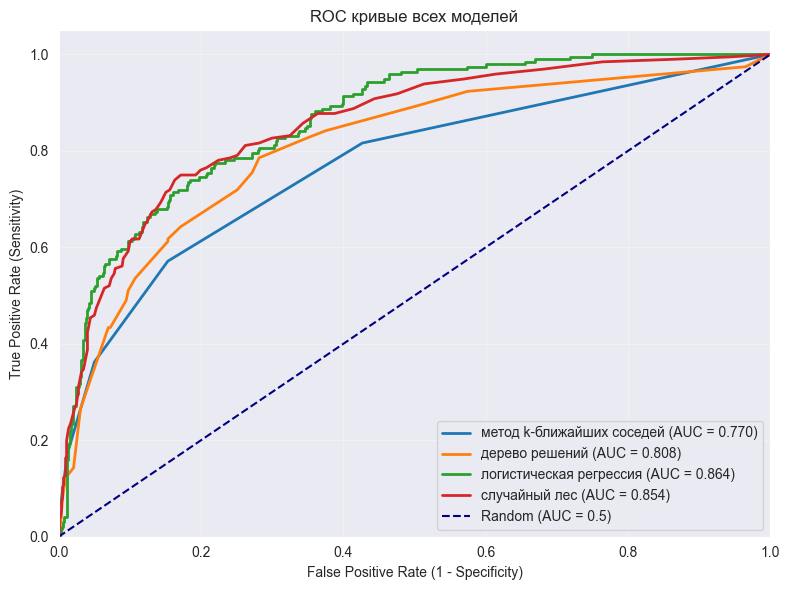

In [79]:
# python
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors

for idx, (name, y_prob) in enumerate(probabilities.items()):
    fpr, tpr, _ = roc_curve(y_test,  y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, color=colors[idx % len(colors)],
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random (AUC = 0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC кривые всех моделей')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Все модели показывают себя значительно лучше случайного угадывания.

Лучшего всего себя показывает логистическая кривая с AUC = 0.864, что что свидетельствует о хорошей дискриминационной способности модели.

Случайный лес близок с AUC = 0.854, однако на всем диапазоне уступает логистической кривой.

Метод k-ближайших соседей самый слабый с AUC = 0.770, но даже он показывает хороший результат.

# Вывод

В ходе выполнения лабораторной работы были изучены алгоритмы и методы классификации, получены навыки их практического применения на реальных данных.

На основании реального датасета с данными о кредитах построены рабочие модели, предсказывающие, сможет ли криент выплатить кредит. Были построены модели четырьмя алгоритмами классификации: метод k-ближайших соседей, дерево решений, логистическая регрессия и случайный лес.

Анализ моделей по метрикам f-score, precision, recall и confusion matrix показал, что все из моделей справляются с задачей хорошо. Однако, наилучшая модель зависит от требований бизнеса.

Если приоритет - выявить как можно больше дефолтов (минимум FN), то лучше подходит логистическая регрессия: лучший recall, лучший F1 и сбалансированная точность.

Если приоритет - сократить ошибочные отказы (минимум FP), то лучше подходит случайный лес: лучший precision и точность.
